In [1]:
!pip install librosa matplotlib numpy wfdb scipy scikit-learn

In [2]:
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import wfdb
from scipy.signal import find_peaks
from scipy.signal import spectrogram
from scipy.signal import welch
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# Predictive Maintenance

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        96
           1       1.00      1.00      1.00       104

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

Confusion Matrix:
 [[ 96   0]
 [  0 104]]


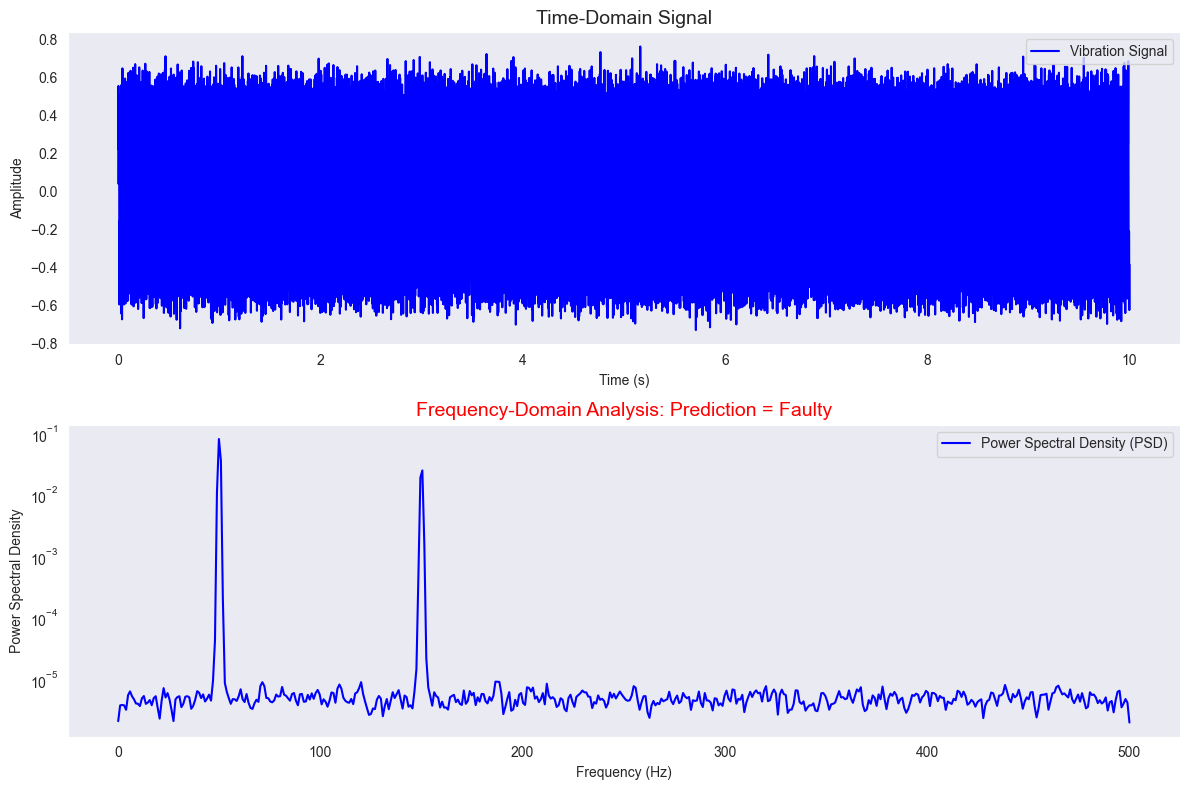

In [3]:
# Simulate realistic vibration signals
def simulate_realistic_signal(fault_frequency=None, duration=10, fs=1000, noise_level=0.05):
    """
    Simulates realistic vibration signals with noise and optional faults.
    - fault_frequency: Frequency component to simulate a fault.
    - duration: Signal duration in seconds.
    - fs: Sampling frequency.
    - noise_level: Intensity of random noise.
    """
    t = np.linspace(0, duration, fs * duration, endpoint=False)
    normal_signal = 0.5 * np.sin(2 * np.pi * 50 * t)  # Normal vibration at 50 Hz

    # Add random noise (background/environmental noise)
    noise = noise_level * np.random.normal(size=len(t))

    # Add fault if specified
    if fault_frequency:
        fault_signal = 0.3 * np.sin(2 * np.pi * fault_frequency * t)  # Fault vibration
        return normal_signal + fault_signal + noise, t
    return normal_signal + noise, t


# Generate training data
num_samples = 500  # Number of samples per class
fs = 1000
signals = []
labels = []

# Generate normal signals
for _ in range(num_samples):
    signal, _ = simulate_realistic_signal(fault_frequency=None, fs=fs, noise_level=0.05)
    signals.append(signal)
    labels.append(0)  # Label 0 for normal

# Generate faulty signals
fault_frequencies = [100, 150, 200]  # Fault frequencies
for _ in range(num_samples):
    fault_freq = np.random.choice(fault_frequencies)  # Random fault frequency
    signal, _ = simulate_realistic_signal(fault_frequency=fault_freq, fs=fs, noise_level=0.05)
    signals.append(signal)
    labels.append(1)  # Label 1 for faulty


# Compute PSD features
def compute_psd_features(signals, fs=1000):
    """
    Compute Power Spectral Density (PSD) features for a list of signals.
    """
    psd_features = []
    for signal in signals:
        _, psd = welch(signal, fs, nperseg=1024)
        psd_features.append(psd)
    return np.array(psd_features)


psd_features = compute_psd_features(signals, fs)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(psd_features, labels, test_size=0.2, random_state=42)

# Train an AI model (Random Forest)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate the model
y_pred = clf.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


# Visualize PSD and prediction for a realistic test signal
def visualize_prediction(signal, fs, clf):
    """
    Visualizes the signal, its PSD, and the model's prediction.
    """
    # Compute PSD
    f, psd = welch(signal, fs, nperseg=1024)

    # Predict
    psd_input = psd.reshape(1, -1)
    prediction = clf.predict(psd_input)
    label = "Faulty" if prediction[0] == 1 else "Normal"
    color = "red" if prediction[0] == 1 else "green"

    # Plot time-domain signal
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    plt.plot(t, signal, label="Vibration Signal", color="blue")
    plt.title("Time-Domain Signal", fontsize=14)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid()
    plt.legend()

    # Plot PSD
    plt.subplot(2, 1, 2)
    plt.semilogy(f, psd, label="Power Spectral Density (PSD)", color="blue")
    plt.title(f"Frequency-Domain Analysis: Prediction = {label}", fontsize=14, color=color)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power Spectral Density")
    plt.grid()
    plt.legend()

    plt.tight_layout()
    plt.show()


# Test the visualization on a new realistic signal
test_signal, t = simulate_realistic_signal(fault_frequency=150, fs=fs, noise_level=0.05)  # Faulty signal
visualize_prediction(test_signal, fs, clf)

# Heartbeat Anomaly Detection (Healthcare)

Generating record list for: 100
Generating list of all files for: 100
Finished downloading files
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2



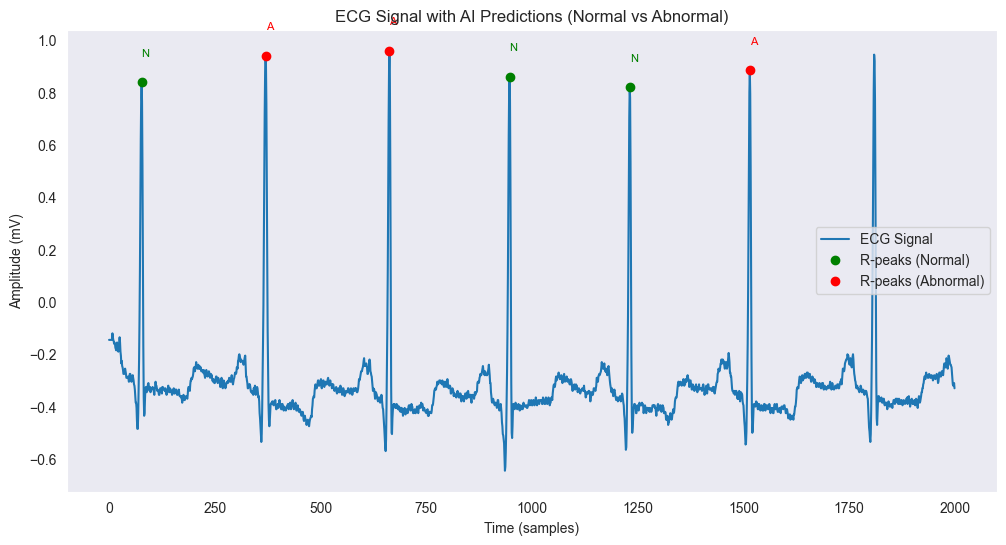

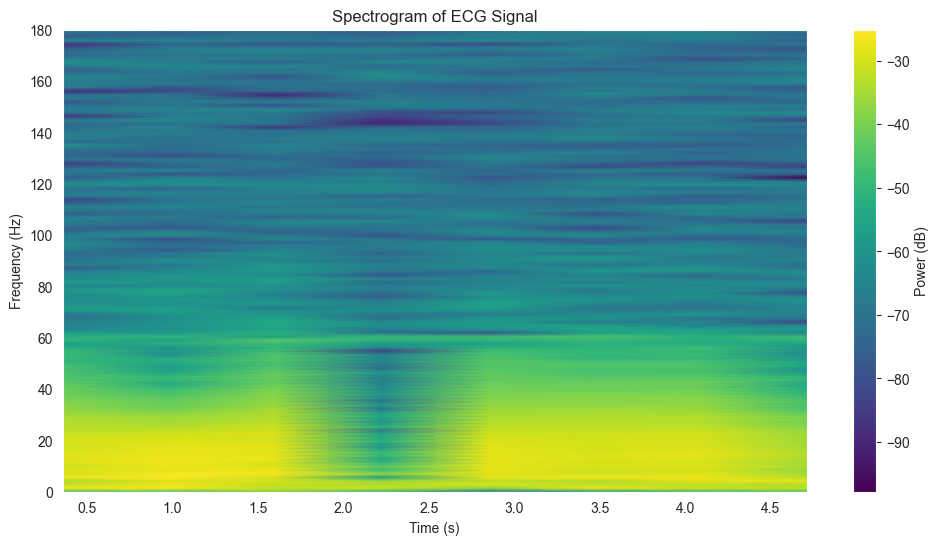

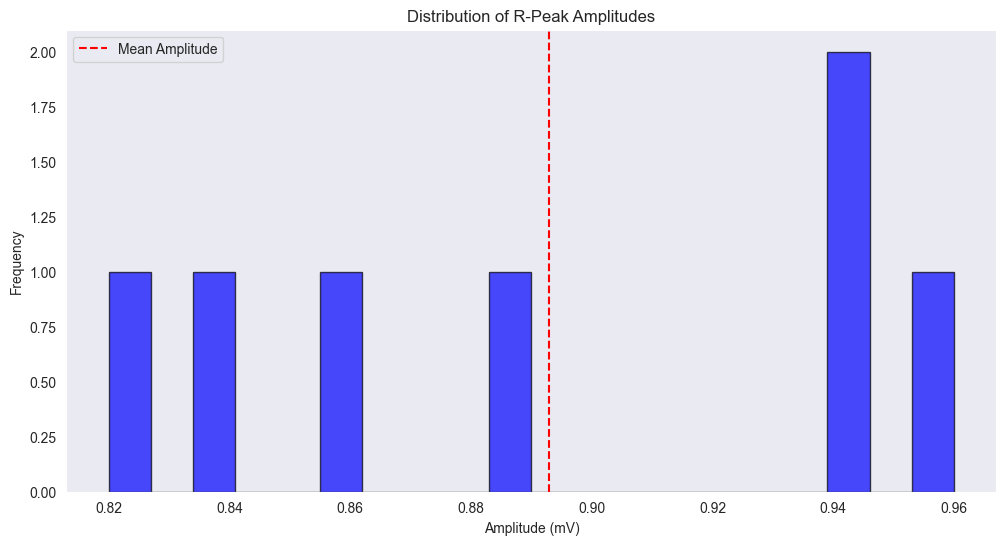

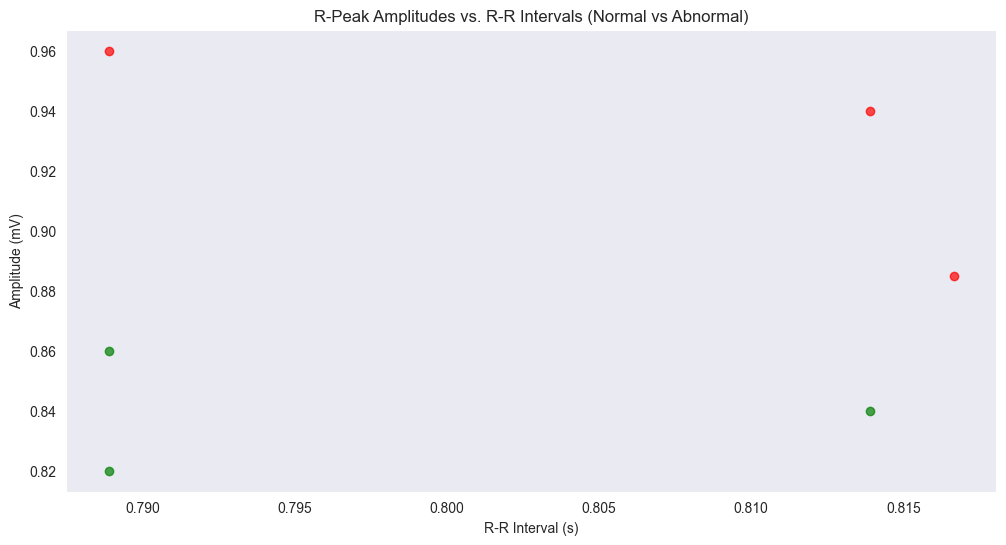

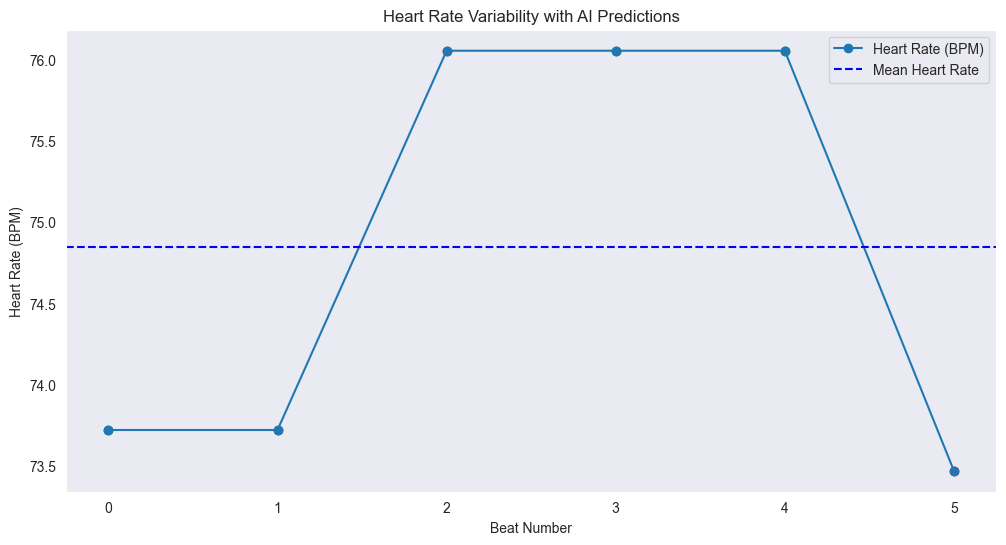

In [4]:
# Download the record from PhysioNet
wfdb.dl_database('mitdb', './mitdb', records=['100'])

# Load the ECG signal
record = wfdb.rdrecord('./mitdb/100', sampto=2000)
ecg_signal = record.p_signal[:, 0]
fs = record.fs  # Sampling frequency

# Extract R-peaks
peaks, properties = find_peaks(ecg_signal, height=0.5, distance=fs / 2)

# Calculate R-peak amplitudes and R-R intervals
r_peak_amplitudes = ecg_signal[peaks]
rr_intervals = np.diff(peaks) / fs  # Time differences between successive R-peaks
heart_rate = 60 / rr_intervals  # Convert to BPM

# Create features for AI model
X = np.column_stack((r_peak_amplitudes[:-1], rr_intervals))  # Features: Amplitude and R-R interval
y = np.random.choice([0, 1], size=len(X), p=[0.8, 0.2])  # Simulated labels (0 = Normal, 1 = Abnormal)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train an AI model (Random Forest Classifier)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate the model
y_pred = clf.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Use the model to predict on the full dataset
predictions = clf.predict(X)

# Visualization 1: ECG Signal with AI predictions
plt.figure(figsize=(12, 6))
plt.plot(ecg_signal, label="ECG Signal")

# Annotate R-peaks with AI predictions
for i, peak in enumerate(peaks[:-1]):
    color = "green" if predictions[i] == 0 else "red"  # Normal: Green, Abnormal: Red
    plt.plot(peak, ecg_signal[peak], "o", color=color)
    plt.text(peak, ecg_signal[peak] + 0.1, f"{'N' if predictions[i] == 0 else 'A'}", color=color, fontsize=8)

plt.title("ECG Signal with AI Predictions (Normal vs Abnormal)")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude (mV)")
plt.legend(["ECG Signal", "R-peaks (Normal)", "R-peaks (Abnormal)"])
plt.grid()
plt.show()

# Visualization 2: Signal Spectrogram
frequencies, times, Sxx = spectrogram(ecg_signal, fs)
plt.figure(figsize=(12, 6))
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading="gouraud", cmap="viridis")
plt.colorbar(label="Power (dB)")
plt.title("Spectrogram of ECG Signal")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.show()

# Visualization 3: Histogram of R-peak Amplitudes
plt.figure(figsize=(12, 6))
plt.hist(r_peak_amplitudes, bins=20, color="blue", alpha=0.7, edgecolor="black")
plt.title("Distribution of R-Peak Amplitudes")
plt.xlabel("Amplitude (mV)")
plt.ylabel("Frequency")
plt.axvline(np.mean(r_peak_amplitudes), color="red", linestyle="--", label="Mean Amplitude")
plt.legend()
plt.grid()
plt.show()

# Visualization 4: Scatter Plot (Amplitude vs. R-R Interval)
plt.figure(figsize=(12, 6))
for i in range(len(X)):
    color = "green" if predictions[i] == 0 else "red"
    plt.scatter(X[i, 1], X[i, 0], color=color, alpha=0.7)
plt.title("R-Peak Amplitudes vs. R-R Intervals (Normal vs Abnormal)")
plt.xlabel("R-R Interval (s)")
plt.ylabel("Amplitude (mV)")
plt.grid()
plt.show()

# Visualization 5: Heart Rate Variability (HRV)
plt.figure(figsize=(12, 6))
plt.plot(heart_rate, label="Heart Rate (BPM)", marker="o", linestyle="-")
for i, hr in enumerate(heart_rate):
    color = "green" if predictions[i] == 0 else "red"
    plt.scatter(i, hr, color=color)
plt.title("Heart Rate Variability with AI Predictions")
plt.xlabel("Beat Number")
plt.ylabel("Heart Rate (BPM)")
plt.axhline(np.mean(heart_rate), color="blue", linestyle="--", label="Mean Heart Rate")
plt.legend()
plt.grid()
plt.show()


# Acoustic Anomaly Detection

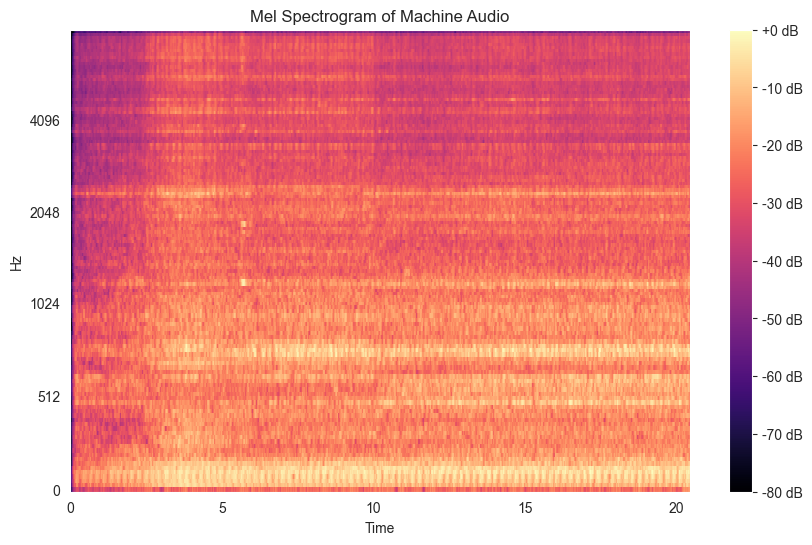

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.99      0.88       101
           1       0.50      0.04      0.07        27

    accuracy                           0.79       128
   macro avg       0.65      0.51      0.48       128
weighted avg       0.73      0.79      0.71       128



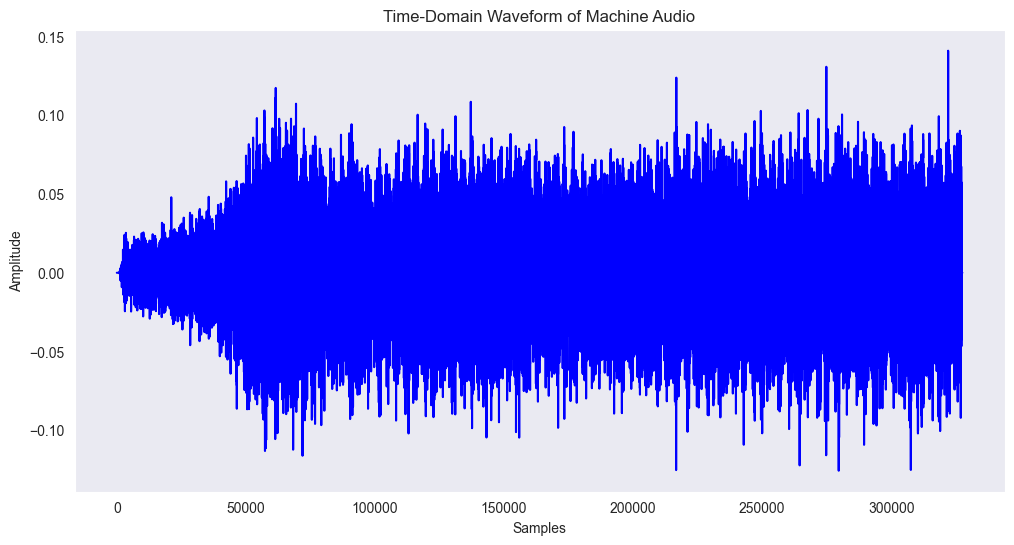

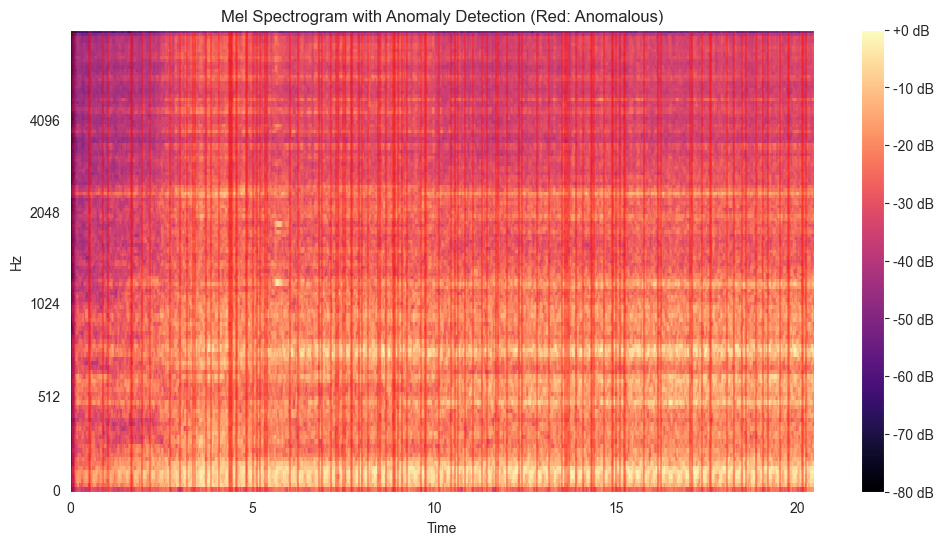

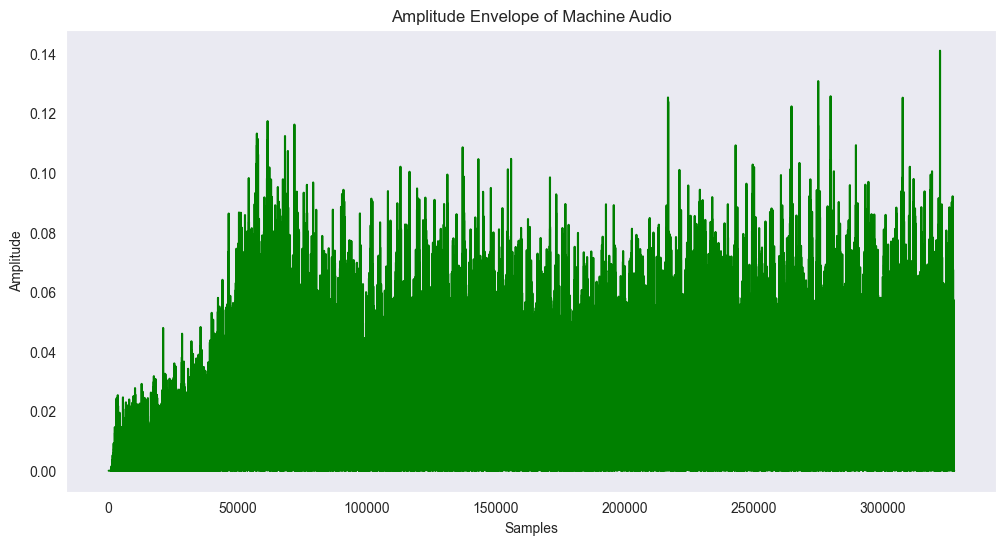

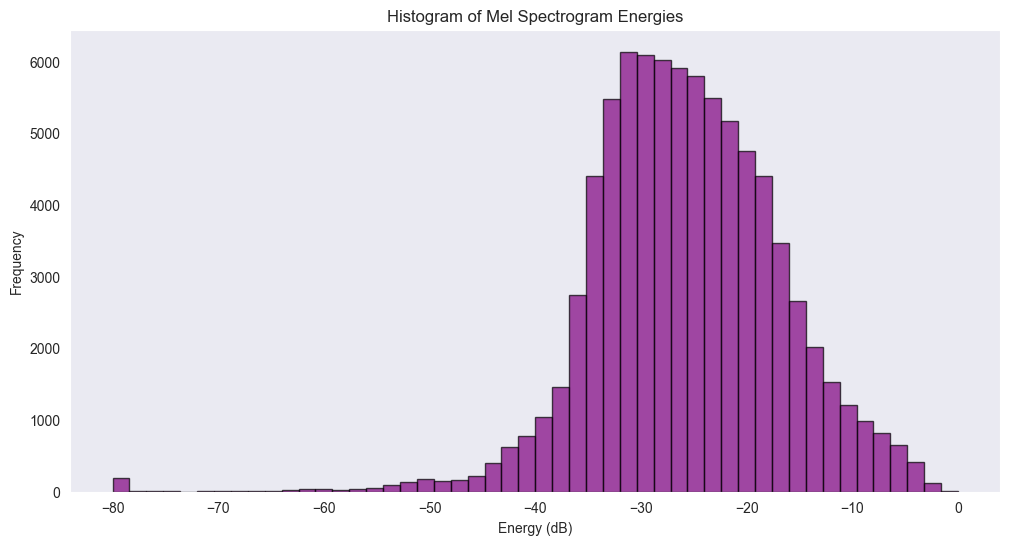

In [6]:
# Load machine audio
audio, sr = librosa.load("asset/machine-audio.mp3", sr=16000)

# Generate Mel spectrogram
mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128, fmax=8000)
log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

# Visualize the Mel Spectrogram
plt.figure(figsize=(10, 6))
librosa.display.specshow(log_mel_spectrogram, sr=sr, x_axis='time', y_axis='mel', fmax=8000, cmap='magma')
plt.colorbar(format="%+2.0f dB")
plt.title("Mel Spectrogram of Machine Audio")
plt.show()

# Create Features for AI-Based Anomaly Detection
# Divide the Mel spectrogram into segments for analysis
segments = log_mel_spectrogram.T  # Shape: (time, features)
segment_labels = np.random.choice([0, 1], size=segments.shape[0],
                                  p=[0.8, 0.2])  # Simulated labels (0: Normal, 1: Anomalous)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(segments, segment_labels, test_size=0.2, random_state=42)

# Train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate the model
y_pred = clf.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Use the model to predict anomalies on the full spectrogram
predictions = clf.predict(segments)

# Visualization 1: Time-Domain Waveform
plt.figure(figsize=(12, 6))
plt.plot(audio, color="blue")
plt.title("Time-Domain Waveform of Machine Audio")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

# Visualization 2: Mel Spectrogram with AI Predictions
plt.figure(figsize=(12, 6))
librosa.display.specshow(log_mel_spectrogram, sr=sr, x_axis='time', y_axis='mel', fmax=8000, cmap='magma')
for i, pred in enumerate(predictions):
    if pred == 1:  # Highlight anomalous regions
        plt.axvline(i * (audio.shape[0] / len(predictions)) / sr, color="red", alpha=0.3)
plt.colorbar(format="%+2.0f dB")
plt.title("Mel Spectrogram with Anomaly Detection (Red: Anomalous)")
plt.show()

# Visualization 3: Amplitude Envelope
amplitude_envelope = np.abs(audio)
plt.figure(figsize=(12, 6))
plt.plot(amplitude_envelope, color="green")
plt.title("Amplitude Envelope of Machine Audio")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

# Visualization 4: Histogram of Mel Spectrogram Energies
plt.figure(figsize=(12, 6))
plt.hist(log_mel_spectrogram.flatten(), bins=50, color="purple", alpha=0.7, edgecolor="black")
plt.title("Histogram of Mel Spectrogram Energies")
plt.xlabel("Energy (dB)")
plt.ylabel("Frequency")
plt.grid()
plt.show()


# Voice Bioprint

/Users/matteorizzo/PycharmProjects/curated-ml-examples/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/matteorizzo/PycharmProjects/curated-ml-examples/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/matteorizzo/PycharmProjects/curated-ml-examples/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` paramete

Classification Report:
               precision    recall  f1-score   support

           0       0.86      1.00      0.92        12
           1       0.00      0.00      0.00         2

    accuracy                           0.86        14
   macro avg       0.43      0.50      0.46        14
weighted avg       0.73      0.86      0.79        14



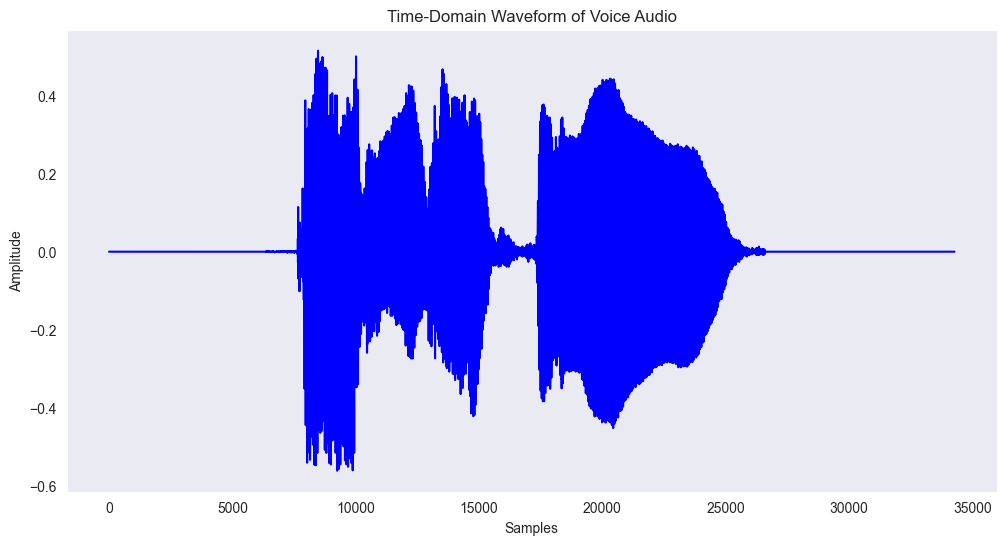

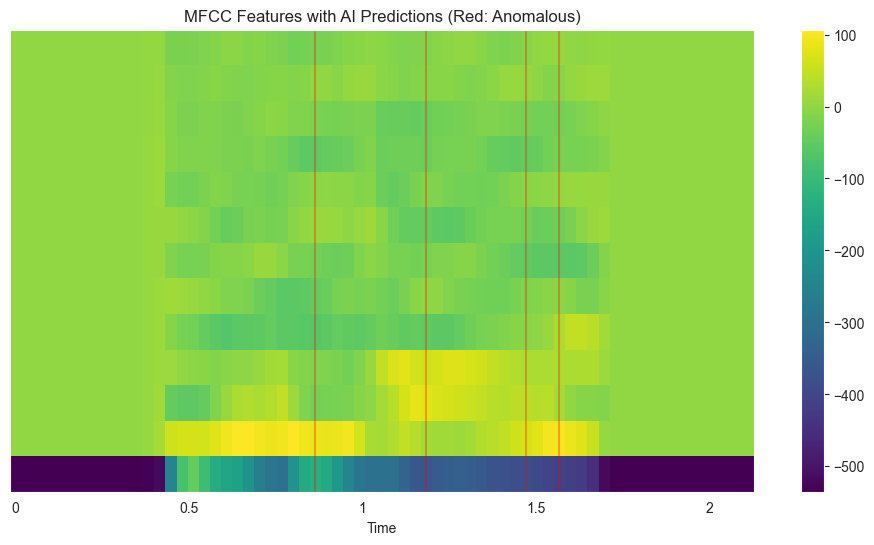

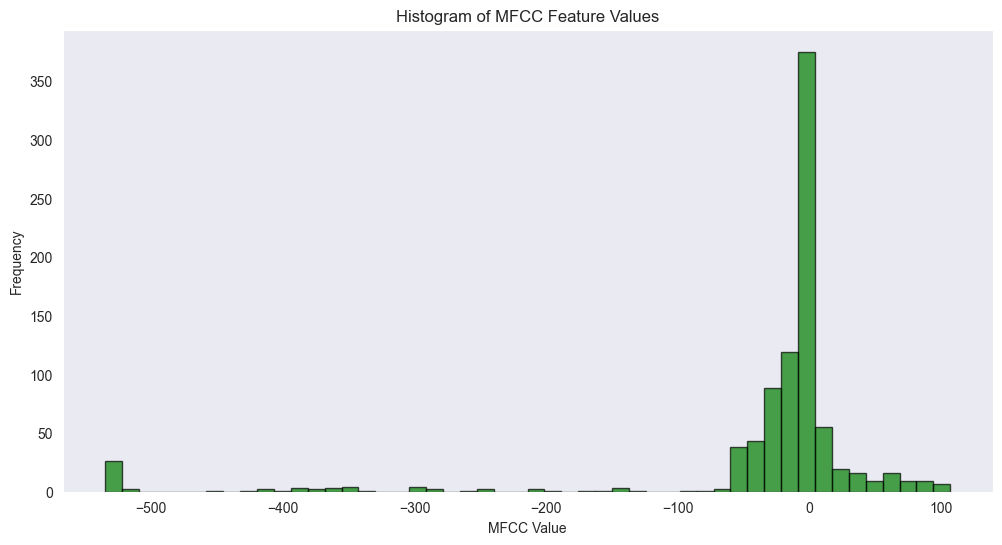

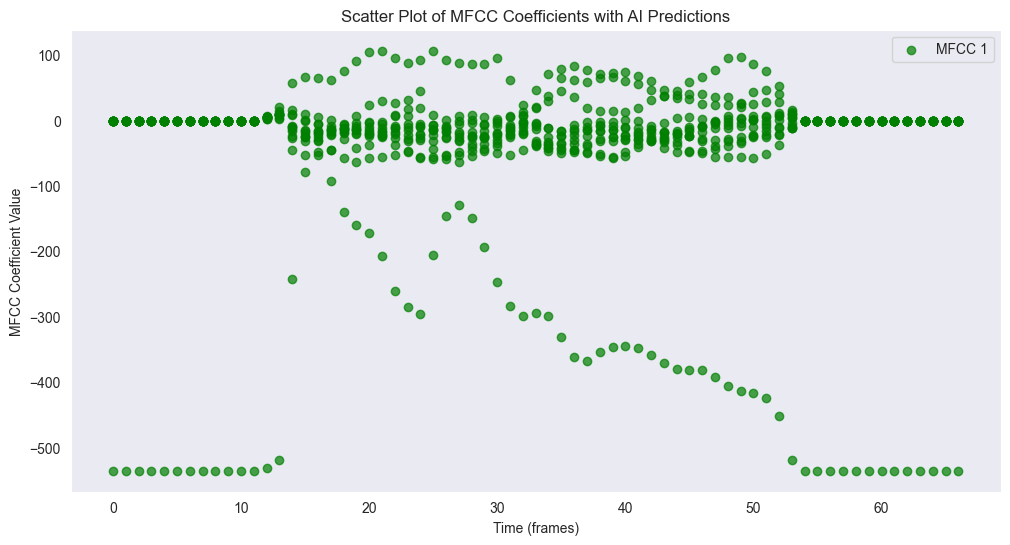

In [7]:
# Load voice audio
audio, sr = librosa.load("asset/voice.mp3", sr=16000)

# Extract MFCC features
mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13).T  # Transpose for time-first format

# Simulate labels for AI-based classification
labels = np.random.choice([0, 1], size=mfcc.shape[0], p=[0.8, 0.2])  # 0 = Normal, 1 = Anomalous

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(mfcc, labels, test_size=0.2, random_state=42)

# Train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate the model
y_pred = clf.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Use the model to predict on the full dataset
predictions = clf.predict(mfcc)

# Visualization 1: Time-Domain Waveform
plt.figure(figsize=(12, 6))
plt.plot(audio, color="blue")
plt.title("Time-Domain Waveform of Voice Audio")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

# Visualization 2: MFCC Features with AI Predictions
plt.figure(figsize=(12, 6))
librosa.display.specshow(mfcc.T, x_axis='time', sr=sr, cmap='viridis')
for i, pred in enumerate(predictions):
    if pred == 1:  # Highlight anomalous regions
        plt.axvline(i * (audio.shape[0] / len(predictions)) / sr, color="red", alpha=0.3)
plt.colorbar()
plt.title("MFCC Features with AI Predictions (Red: Anomalous)")
plt.show()

# Visualization 3: Histogram of MFCC Feature Values
plt.figure(figsize=(12, 6))
plt.hist(mfcc.flatten(), bins=50, color="green", alpha=0.7, edgecolor="black")
plt.title("Histogram of MFCC Feature Values")
plt.xlabel("MFCC Value")
plt.ylabel("Frequency")
plt.grid()
plt.show()

# Visualization 4: Scatter Plot of MFCC Coefficients
plt.figure(figsize=(12, 6))
for i in range(mfcc.shape[1]):  # Loop through MFCC coefficients
    color = "green" if predictions[i] == 0 else "red"
    plt.scatter(np.arange(mfcc.shape[0]), mfcc[:, i], color=color, alpha=0.7, label=f"MFCC {i + 1}" if i < 1 else "")
plt.title("Scatter Plot of MFCC Coefficients with AI Predictions")
plt.xlabel("Time (frames)")
plt.ylabel("MFCC Coefficient Value")
plt.grid()
plt.legend()
plt.show()


# Structural Health Monitoring

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        44
           1       1.00      1.00      1.00        36

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80



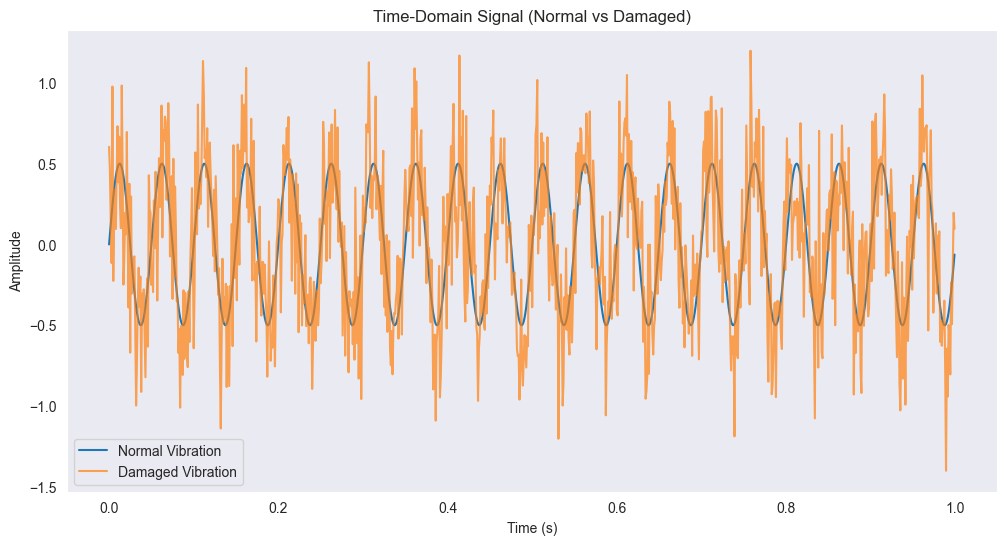

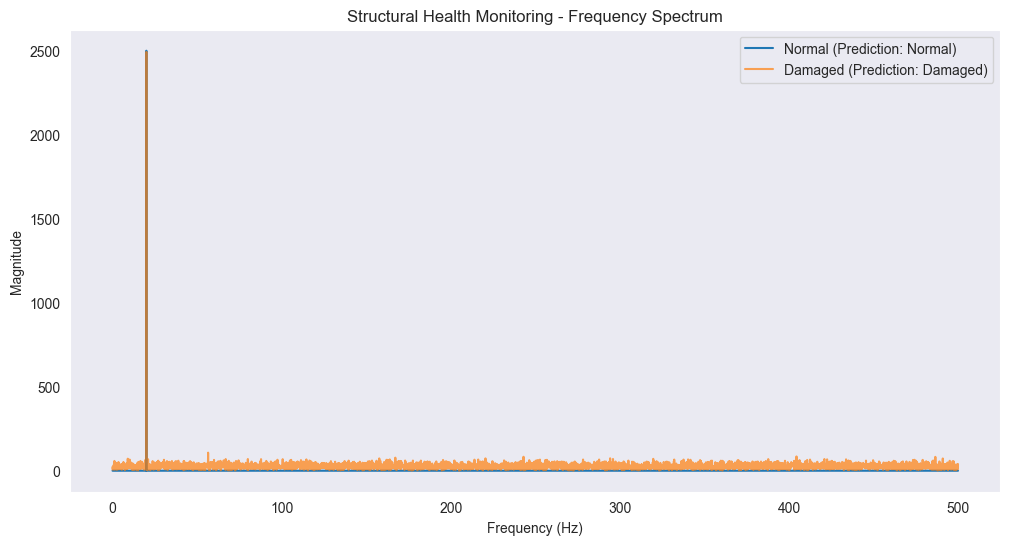

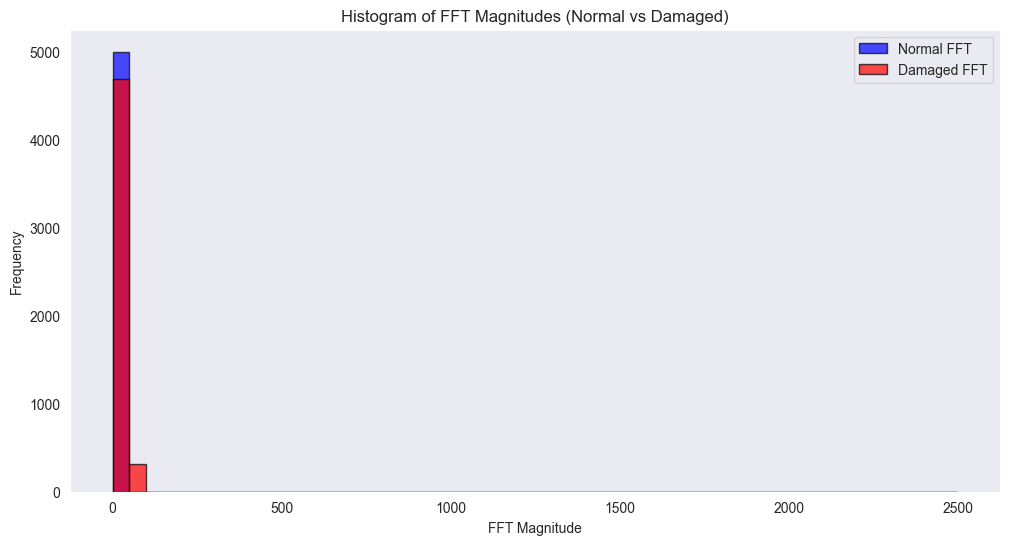

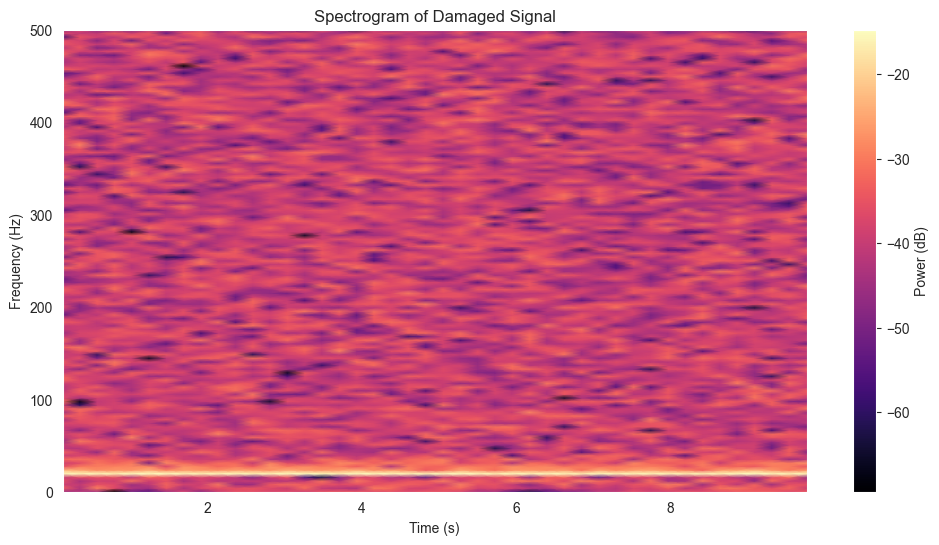

In [8]:
# Simulation Parameters
fs = 1000  # Sampling frequency
t = np.linspace(0, 10, fs * 10, endpoint=False)  # 10 seconds

# Simulate normal and damaged structure signals
normal_vibration = 0.5 * np.sin(2 * np.pi * 20 * t)  # Normal vibration at 20 Hz
damage_vibration = normal_vibration + 0.3 * np.random.randn(len(t))  # Add noise to simulate damage


# Generate Frequency Spectrum Features
def compute_fft_features(signal, fs):
    fft_result = np.fft.fft(signal)
    frequencies = np.fft.fftfreq(len(signal), d=1 / fs)
    return frequencies[:len(frequencies) // 2], np.abs(fft_result)[:len(frequencies) // 2]


frequencies, fft_normal = compute_fft_features(normal_vibration, fs)
_, fft_damaged = compute_fft_features(damage_vibration, fs)

# AI Classification - Create Dataset
num_samples = 200  # Number of samples per class
signals = []
labels = []

# Generate Normal Signals
for _ in range(num_samples):
    signal = 0.5 * np.sin(2 * np.pi * 20 * t) + 0.05 * np.random.randn(len(t))  # Add small noise
    signals.append(compute_fft_features(signal, fs)[1])
    labels.append(0)  # Label 0 for normal

# Generate Damaged Signals
for _ in range(num_samples):
    signal = 0.5 * np.sin(2 * np.pi * 20 * t) + 0.3 * np.random.randn(len(t))  # Add larger noise
    signals.append(compute_fft_features(signal, fs)[1])
    labels.append(1)  # Label 1 for damaged

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(signals, labels, test_size=0.2, random_state=42)

# Train a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate the Model
y_pred = clf.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Predict on FFT of Normal and Damaged Signals
normal_prediction = clf.predict([fft_normal])
damaged_prediction = clf.predict([fft_damaged])

# Visualization 1: Time-Domain Signal
plt.figure(figsize=(12, 6))
plt.plot(t[:1000], normal_vibration[:1000], label="Normal Vibration")
plt.plot(t[:1000], damage_vibration[:1000], label="Damaged Vibration", alpha=0.7)
plt.title("Time-Domain Signal (Normal vs Damaged)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()

# Visualization 2: Frequency Spectrum with Predictions
plt.figure(figsize=(12, 6))
plt.plot(frequencies, fft_normal, label=f"Normal (Prediction: {'Normal' if normal_prediction[0] == 0 else 'Damaged'})")
plt.plot(frequencies, fft_damaged,
         label=f"Damaged (Prediction: {'Damaged' if damaged_prediction[0] == 1 else 'Normal'})", alpha=0.7)
plt.title("Structural Health Monitoring - Frequency Spectrum")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.legend()
plt.grid()
plt.show()

# Visualization 3: Histogram of FFT Magnitudes
plt.figure(figsize=(12, 6))
plt.hist(fft_normal, bins=50, alpha=0.7, label="Normal FFT", color="blue", edgecolor="black")
plt.hist(fft_damaged, bins=50, alpha=0.7, label="Damaged FFT", color="red", edgecolor="black")
plt.title("Histogram of FFT Magnitudes (Normal vs Damaged)")
plt.xlabel("FFT Magnitude")
plt.ylabel("Frequency")
plt.legend()
plt.grid()
plt.show()

# Visualization 4: Spectrogram of Damaged Signal
from scipy.signal import spectrogram

frequencies, times, Sxx = spectrogram(damage_vibration, fs)

plt.figure(figsize=(12, 6))
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud', cmap='magma')
plt.colorbar(label="Power (dB)")
plt.title("Spectrogram of Damaged Signal")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.grid()
plt.show()


# Seismic Data Analysis

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2



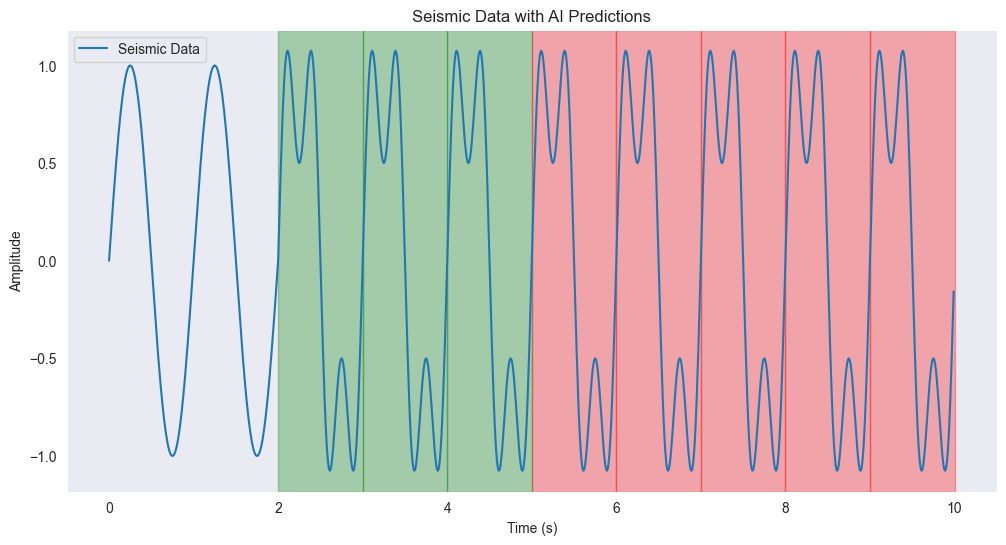

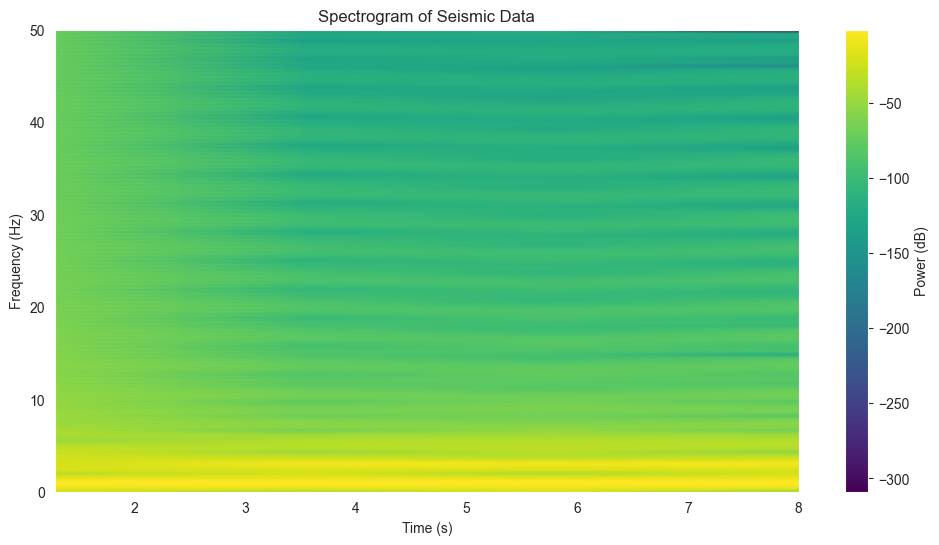

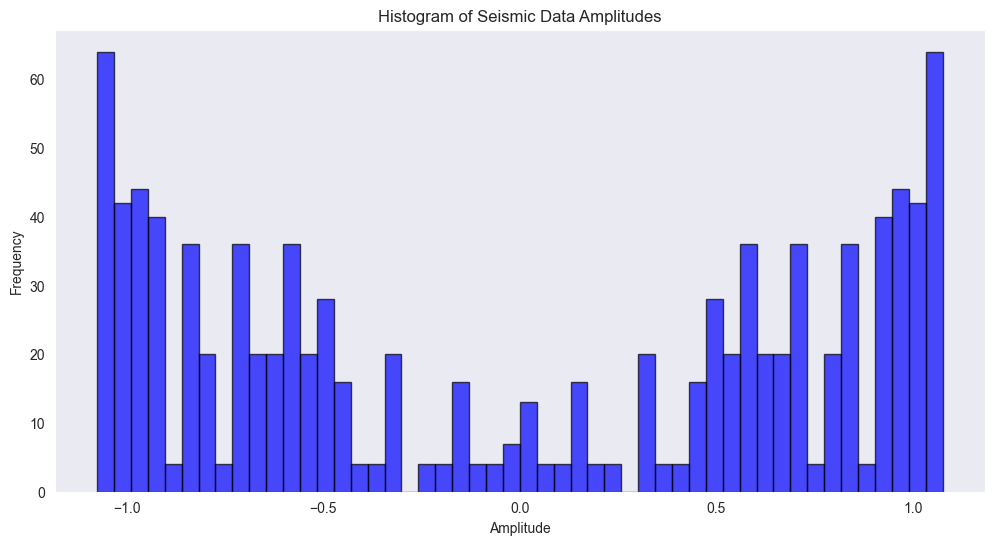

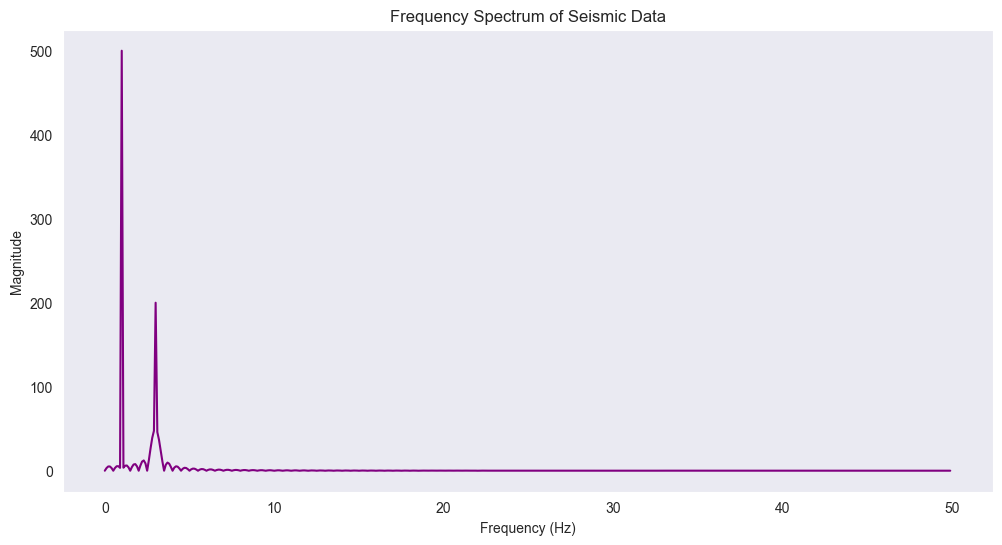

In [9]:
# Simulation Parameters
fs = 100  # Sampling frequency
t = np.linspace(0, 10, fs * 10, endpoint=False)  # 10 seconds

# Simulate seismic data
p_wave = np.sin(2 * np.pi * 1 * t)  # Low-frequency P-wave
s_wave = 0.5 * np.sin(2 * np.pi * 3 * t)  # Higher frequency S-wave
seismic_data = p_wave + np.heaviside(t - 2, 1) * s_wave  # S-wave starts after 2 seconds


# Create features for AI classification
def compute_fft_features(signal, fs):
    fft_result = np.fft.fft(signal)
    frequencies = np.fft.fftfreq(len(signal), d=1 / fs)
    return frequencies[:len(frequencies) // 2], np.abs(fft_result)[:len(frequencies) // 2]


# Divide seismic data into segments for feature extraction
segment_size = fs  # 1-second segments
num_segments = len(seismic_data) // segment_size
segments = [seismic_data[i * segment_size:(i + 1) * segment_size] for i in range(num_segments)]

# Extract FFT features for each segment
fft_features = [compute_fft_features(segment, fs)[1] for segment in segments]

# Simulate labels: 0 = Noise, 1 = P-wave, 2 = S-wave
labels = [0] * 2 + [1] * 3 + [2] * 5  # Example: 2 noise, 3 P-wave, 5 S-wave

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(fft_features, labels, test_size=0.2, random_state=42)

# Train a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate the model
y_pred = clf.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Predict on full dataset
predictions = clf.predict(fft_features)

# Visualization 1: Time-Domain Signal
plt.figure(figsize=(12, 6))
plt.plot(t, seismic_data, label="Seismic Data")
for i, pred in enumerate(predictions):
    if pred == 1:
        plt.axvspan(i, i + 1, color="green", alpha=0.3, label="P-wave" if i == 0 else None)
    elif pred == 2:
        plt.axvspan(i, i + 1, color="red", alpha=0.3, label="S-wave" if i == 0 else None)
plt.title("Seismic Data with AI Predictions")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()

# Visualization 2: Spectrogram
frequencies, times, Sxx = spectrogram(seismic_data, fs)
plt.figure(figsize=(12, 6))
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud', cmap='viridis')
plt.colorbar(label="Power (dB)")
plt.title("Spectrogram of Seismic Data")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.grid()
plt.show()

# Visualization 3: Histogram of Amplitudes
plt.figure(figsize=(12, 6))
plt.hist(seismic_data, bins=50, color="blue", alpha=0.7, edgecolor="black")
plt.title("Histogram of Seismic Data Amplitudes")
plt.xlabel("Amplitude")
plt.ylabel("Frequency")
plt.grid()
plt.show()

# Visualization 4: Frequency Spectrum
frequencies, fft_magnitude = compute_fft_features(seismic_data, fs)
plt.figure(figsize=(12, 6))
plt.plot(frequencies, fft_magnitude, color="purple")
plt.title("Frequency Spectrum of Seismic Data")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.grid()
plt.show()
